# Machine Learning for Data Science 
# Predicting Power Plant Energy Output Using Regression and KNN
## Rajnandini Thopte 


The dataset contains data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.

#### (a) Download the Combined Cycle Power Plant data1 from: https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant


In [239]:
# performing all imports and installing prettytable during execution
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import normalize
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from IPython.display import display, Markdown

In [240]:
from tabulate import tabulate

#### (b) Exploring the data:

#### i. How many rows are in this data set? How many columns? What do the rows and columns represent?

In [241]:
df = pd.read_excel('../data/Folds5x2_pp.xlsx', sheet_name = 'Sheet1')

In [242]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [243]:
num_of_rows = len(df.index)
print ("Number of rows are: " ,num_of_rows)
num_of_cols = df.shape[1]
print ("Number of columns are: " ,num_of_cols)

Number of rows are:  9568
Number of columns are:  5


The rows represent 9568 data point's different parameters collected in a span of 6 years(2006-2011), from a combined cycle power plant (CCPP). The columns consists of features that are:    
1] Temperature (T): Hourly average ambient temperature.  
2] Ambient Pressure (AP): Hourly average ambient pressure.  
3] Relative Humidity (RH): Hourly average relative humidity.  
4] Exhaust Vacuum (V): Exhaust vacuum pressure.   
These can be seen as the Predictors and which predict the hourly energy output of the plant -Energy Output (EP).  

#### ii. Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.  

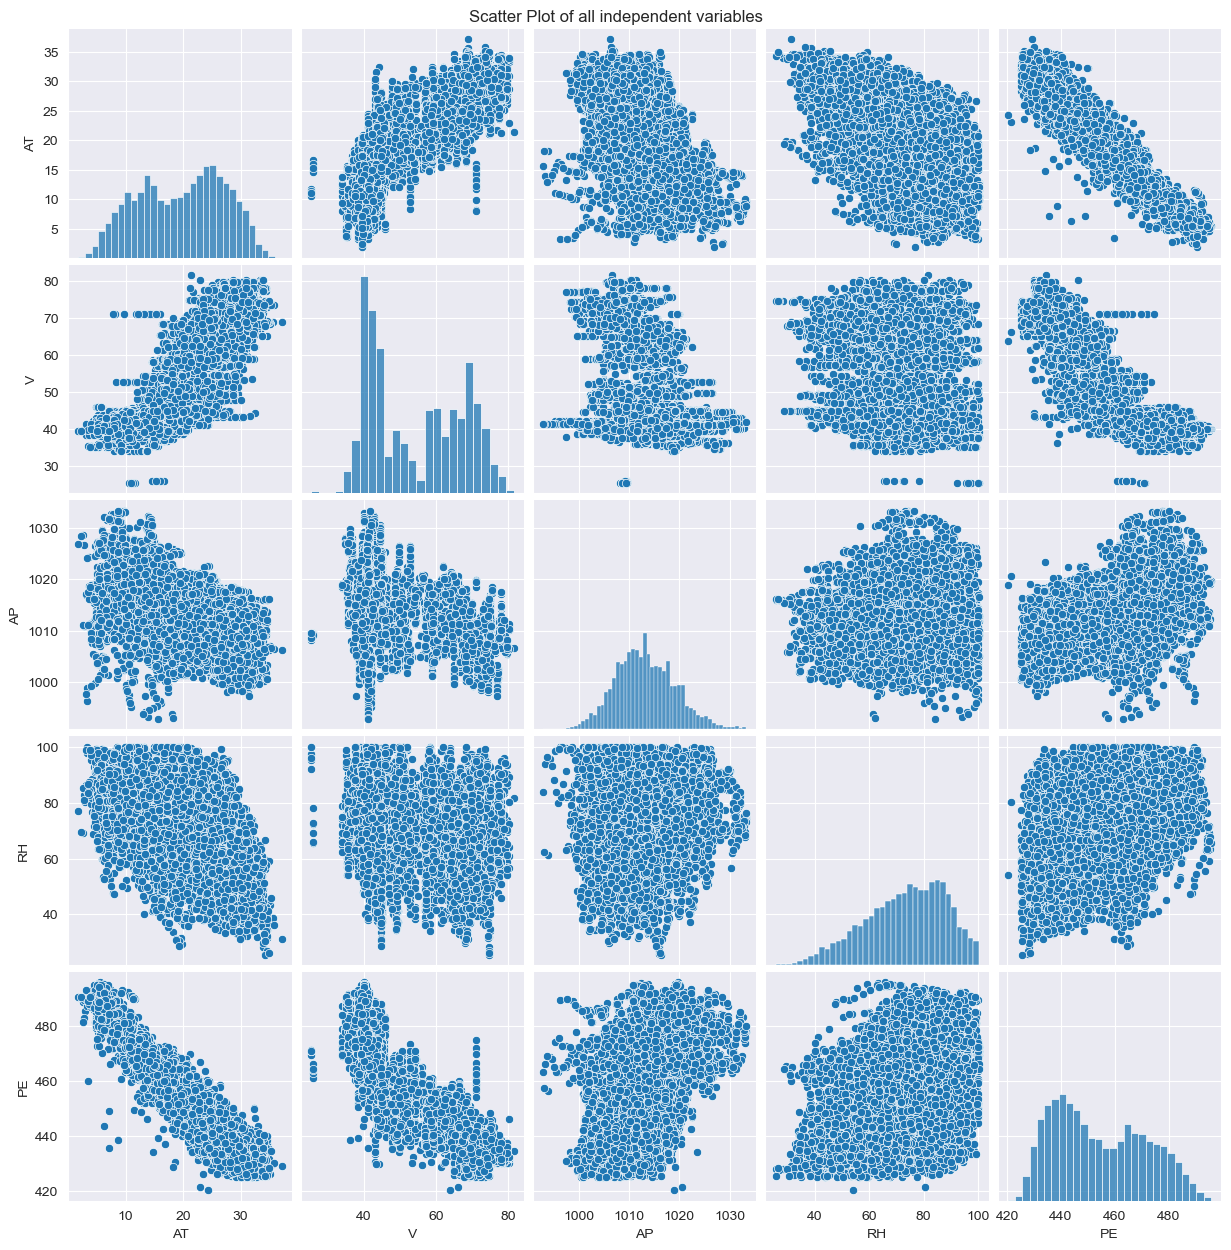

In [244]:
# initializing and defining scatterplot
fig = sns.pairplot(data = df)
fig.fig.suptitle("Scatter Plot of all independent variables", y=1)
plt.show()


Scatter plots can help us in observing the correlation between two variables.The closer the data points come to forming a straight line when plotted, the higher the correlation between the two variables, or the stronger the relationship. 

Plotting correlation matrix to understand better:

In [245]:
correlation = df.corr()
correlation.style.background_gradient(cmap='coolwarm')

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


The correlation matrix represents the pairwise correlations between different variables in your dataset. Correlation values range from -1 to 1, where:  

-A value of 1 indicates a perfect positive correlation, meaning that as one variable increases, the other also increases linearly.   
-A value of -1 indicates a perfect negative correlation, meaning that as one variable increases, the other decreases linearly.  
-A value close to 0 indicates a weak or no linear correlation between the variables.  
 
 What we can infer from the correlation matrix:  

1] Temperature (AT) and Exhaust Vacuum (V) have a strong positive correlation of approximately 0.84. This suggests that as ambient temperature increases, the exhaust vacuum pressure also tends to increase.  

2]Temperature (AT) and Relative Humidity (RH) have a negative correlation of approximately -0.54. This indicates that as ambient temperature increases, relative humidity tends to decrease, and vice versa.  

3] Temperature (AT) and Net Hourly Electrical Energy Output (PE) have a strong negative correlation of approximately -0.95. This suggests that there is a strong inverse relationship between temperature and electrical energy output. As temperature increases, electrical energy output tends to decrease.

4] Exhaust Vacuum (V) and Net Hourly Electrical Energy Output (PE) also have a strong negative correlation of approximately -0.87. Similar to temperature, as exhaust vacuum pressure increases, electrical energy output tends to decrease.

5] Ambient Pressure (AP) has a relatively weak positive correlation with both Temperature (AT) and Net Hourly Electrical Energy Output (PE). This suggests that there is a positive but not very strong relationship between ambient pressure and these variables.  

6] Relative Humidity (RH) has a weak positive correlation with Ambient Pressure (AP) and a weak negative correlation with Net Hourly Electrical Energy Output (PE). These correlations indicate that relative humidity has a limited impact on these variables.  

#### iii. What are the mean, the median, range, first and third quartiles, and in- terquartile ranges of each of the variables in the dataset? Summarize them in a table.

In [246]:
summary = pd.DataFrame({
    "Variable": df.columns,
    "Mean": np.round(df.mean(), 2),
    "Median": np.round(df.median(), 2),
    "Range": np.round(df.max() - df.min(), 2),
    "First Quartile": np.round(df.quantile(0.25), 2),
    "Third Quartile": np.round(df.quantile(0.75), 2),
    "Interquartile Range": np.round(df.quantile(0.75) - df.quantile(0.25), 2)
})

# Convert the summary DataFrame to a tabular format
table = tabulate(summary, headers='keys', tablefmt='psql', showindex=False)

# Print the tabulated summary
print(table)

+------------+---------+----------+---------+------------------+------------------+-----------------------+
| Variable   |    Mean |   Median |   Range |   First Quartile |   Third Quartile |   Interquartile Range |
|------------+---------+----------+---------+------------------+------------------+-----------------------|
| AT         |   19.65 |    20.34 |   35.3  |            13.51 |            25.72 |                 12.21 |
| V          |   54.31 |    52.08 |   56.2  |            41.74 |            66.54 |                 24.8  |
| AP         | 1013.26 |  1012.94 |   40.41 |          1009.1  |          1017.26 |                  8.16 |
| RH         |   73.31 |    74.97 |   74.6  |            63.33 |            84.83 |                 21.5  |
| PE         |  454.37 |   451.55 |   75.5  |           439.75 |           468.43 |                 28.68 |
+------------+---------+----------+---------+------------------+------------------+-----------------------+


#### (c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?


In [247]:
def plot_regression_line(train_x, train_y, feature, response, b_1, b_0, title, figsize):
    # This function plots a scatter plot of the training data and the regression line.
    # It visualizes the linear relationship between a feature (train_x) and a response (train_y).

    # Create a new figure with the specified figsize
    plt.figure(figsize=figsize)
    # Scatter plot of the training data points
    plt.scatter(train_x, train_y, s=2)
    # Generate x-values for the regression line (from the minimum to maximum train_x values)
    x_values = np.arange(train_x.min(), train_x.max())
    # Calculate the corresponding y-values for the regression line using the linear equation
    y_values = b_1 * x_values + b_0
    # Construct the regression line equation as a string
    regression_line = str(b_0) + '+' + feature + '*' + str(b_1)
    # Plot the regression line on the same plot
    plt.plot(x_values, y_values, label=regression_line, color='black')
    # Add a legend to the plot with the regression line equation
    plt.legend(loc='best', fontsize=8)
    # Add a grid to the plot
    plt.grid()
    # Set the title of the plot
    plt.title(title)
    # Label the x-axis with the feature name
    plt.xlabel(feature)
    # Label the y-axis with the response variable name
    plt.ylabel(response)
    # Show the plot
    plt.show()

In [248]:
def plot_standard_residual(train_x, train_y, cook_dist, feature, response):
    # This function creates a pair of subplots to visualize Cook's distance and outliers.
    
    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    
    # Scatter plot of Cook's distance against the feature
    axs[0].scatter(train_x, cook_dist, s=2)
    axs[0].set_xlabel(feature)
    axs[0].set_ylabel("Cook Distance")
    axs[0].grid()

    # Create a color list for the scatter plot points based on Cook's distance values
    # Points with Cook's distance greater than 4/len(train_x) are shown in red, others in blue
    color = ['red' if x > 4 / len(train_x) else '#1f77b4' for x in cook_dist]
    
    # Scatter plot of the training data points with different colors for outliers
    axs[1].scatter(train_x, train_y, c=color, s=2)
    axs[1].set_xlabel(feature)
    axs[1].set_ylabel(response)
    axs[1].grid()
    
    # Add a legend to the second subplot to indicate the outlier points in red
    axs[1].legend(handles=[mpatches.Patch(color='red', label='Outlier')])

    # Display the plot
    plt.show()



In [249]:
#Reference for below- https://medium.com/@faisalshahbaz/relationship-between-r-squared-and-p-value-in-a-regression-2378b1e2e9ce


R-squared (R²) measures how effectively your model accounts for the variation in the data. It's expressed as a percentage, so an R² of 0.1 means your model explains 10% of the variation within the dataset. A higher R² indicates a better fit, as the model explains a larger proportion of the variation.  

The p-value assesses the significance of your model's overall fit compared to a simpler model with no predictors (the intercept-only model). If the p-value is less than a chosen significance level (usually 0.05), it suggests that your model significantly improves upon the intercept-only model and fits the data well.  

This leads to four scenarios:  

Low R-square and Low p-value (p-value <= 0.05):  
Your model explains only a small portion of the data's variation, but it is statistically significant. This situation is better than not having a model at all.  

Low R-square and High p-value (p-value > 0.05):  
Your model explains little data variation, and it is not statistically significant. This is the least favorable scenario as the model doesn't add value.

High R-square and Low p-value:  
Your model explains a substantial portion of the data's variation and is statistically significant. This is the best scenario, indicating a strong and meaningful relationship.  

High R-square and High p-value:  
Your model explains a lot of variation within the data, but it is not statistically significant. In this case, despite the model's explanatory power, it may not be useful due to lack of significance.  

<left><br><font size="6">Analysis: AT</font></br></left>

<left><br><font size="5">1. Plotting regression line</font></br></left>

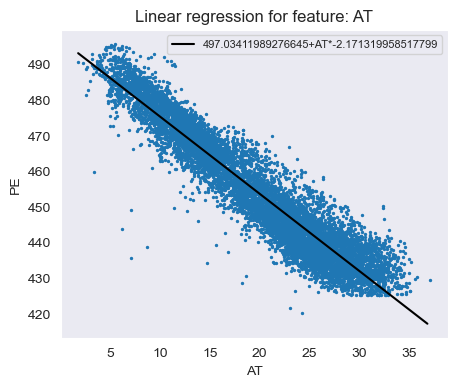

<left><br><font size="5">2. Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:15   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    497.0341      0.156   3177.280      0.0

<left><br><font size="5">3. Outlier Detection</font></br></left>

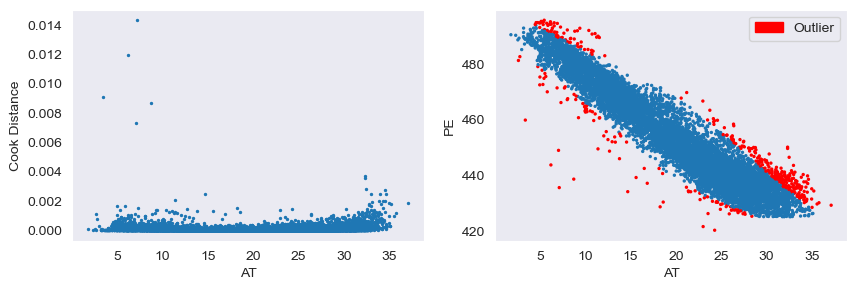

<left><br><font size="5">4. Findings</font></br></left>

+-----------+------------------------------------------------------+
| P Value   | pValue[x_1] = 0.0 < 0.05, => Statistically Signicant |
+-----------+------------------------------------------------------+
| Outliers  | 416 outliers are present                             |
+-----------+------------------------------------------------------+
| r^2 Value | 0.8989475964148236                                   |
+-----------+------------------------------------------------------+


<left><br><font size="6">Analysis: V</font></br></left>

<left><br><font size="5">1. Plotting regression line</font></br></left>

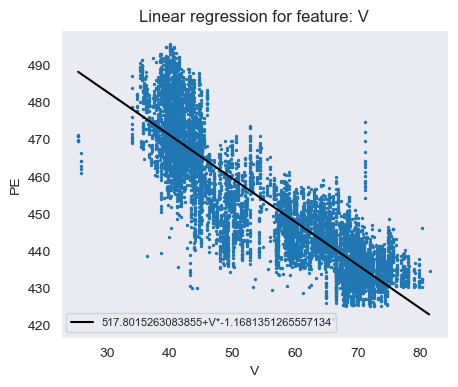

<left><br><font size="5">2. Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:16   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    517.8015      0.378   1370.218      0.0

<left><br><font size="5">3. Outlier Detection</font></br></left>

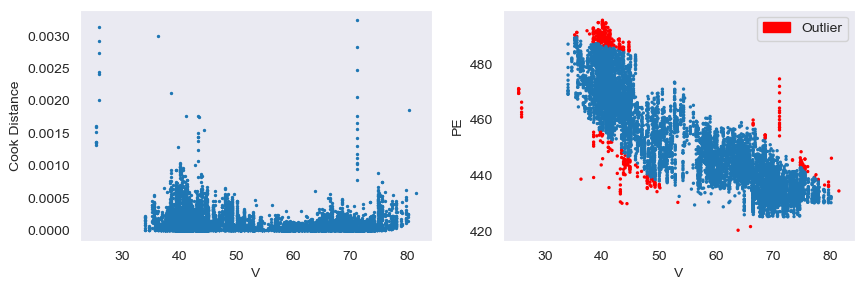

<left><br><font size="5">4. Findings</font></br></left>

+-----------+------------------------------------------------------+
| P Value   | pValue[x_1] = 0.0 < 0.05, => Statistically Signicant |
+-----------+------------------------------------------------------+
| Outliers  | 423 outliers are present                             |
+-----------+------------------------------------------------------+
| r^2 Value | 0.7565177870683979                                   |
+-----------+------------------------------------------------------+


<left><br><font size="6">Analysis: AP</font></br></left>

<left><br><font size="5">1. Plotting regression line</font></br></left>

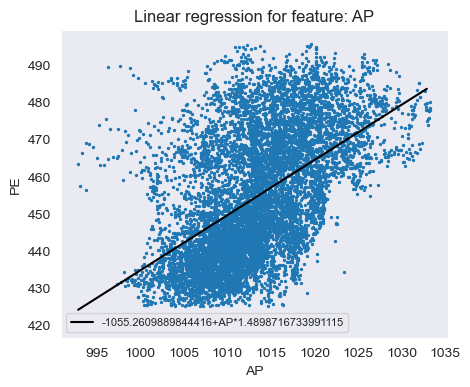

<left><br><font size="5">2. Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:17   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1055.2610     25.459    -41.449      0.0

<left><br><font size="5">3. Outlier Detection</font></br></left>

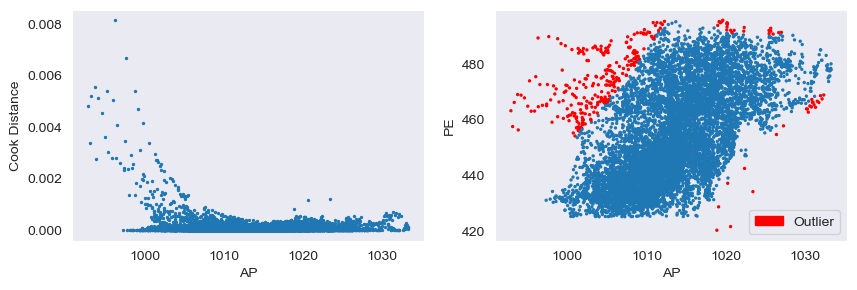

<left><br><font size="5">4. Findings</font></br></left>

+-----------+------------------------------------------------------+
| P Value   | pValue[x_1] = 0.0 < 0.05, => Statistically Signicant |
+-----------+------------------------------------------------------+
| Outliers  | 300 outliers are present                             |
+-----------+------------------------------------------------------+
| r^2 Value | 0.26876865641106784                                  |
+-----------+------------------------------------------------------+


<left><br><font size="6">Analysis: RH</font></br></left>

<left><br><font size="5">1. Plotting regression line</font></br></left>

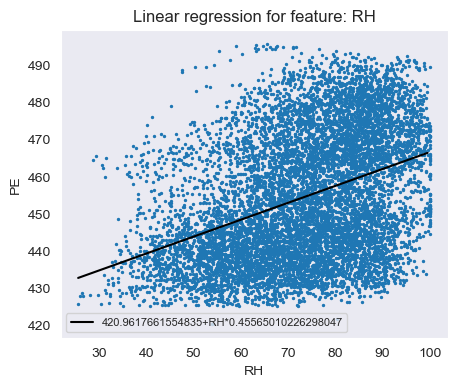

<left><br><font size="5">2. Summary of the model</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:17   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    420.9618      0.823    511.676      0.0

<left><br><font size="5">3. Outlier Detection</font></br></left>

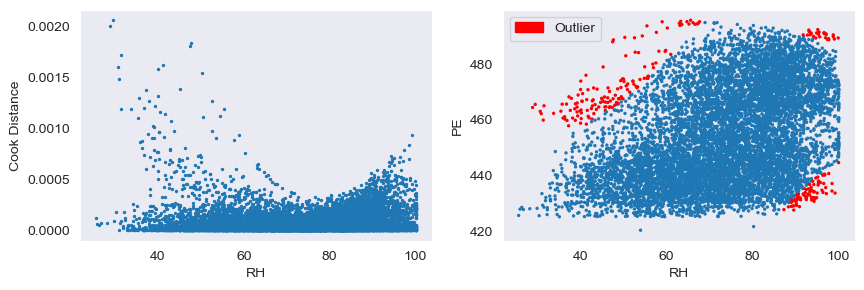

<left><br><font size="5">4. Findings</font></br></left>

+-----------+------------------------------------------------------+
| P Value   | pValue[x_1] = 0.0 < 0.05, => Statistically Signicant |
+-----------+------------------------------------------------------+
| Outliers  | 249 outliers are present                             |
+-----------+------------------------------------------------------+
| r^2 Value | 0.15193944023117445                                  |
+-----------+------------------------------------------------------+


In [250]:
single_regression_coeff = []
features = list(df.columns)
response = features[-1]
features = features[:-1]

#this function conducts a thorough analysis of individual features in the context of linear regression, 
#assessing their significance, impact on the response variable, and the presence of outliers.
def analyze_feature(df, feature, response):
    display(Markdown('<left><br><font size="6">Analysis: {}</font></br></left>'.format(feature)))

    # linear regression fitting and parameter extraction
    model = smf.ols(formula = 'PE ~ ' + feature, data = df).fit()
    b_0, b_1, pValue = model.params[0], model.params[1], model.pvalues[1]
    
    # plotting regression line
    display(Markdown('<left><br><font size="5">1. Plotting regression line</font></br></left>'.format(feature)))
    plot_regression_line(df[feature], df[response], feature, 
                                response, b_1, b_0, "Linear regression for feature: " + feature, (5, 4))
    
    # printing summary
    display(Markdown('<left><br><font size="5">2. Summary of the model</font></br></left>'))
    print(model.summary())
    
    # check if there are any outliers 
    display(Markdown('<left><br><font size="5">3. Outlier Detection</font></br></left>'.format(feature)))
    influence = model.get_influence()
    cook_dist = influence.cooks_distance[0]
    plot_standard_residual(df[feature], df[response], cook_dist, feature, response)
    
    # comment on the model and its parameters
    display(Markdown('<left><br><font size="5">4. Findings</font></br></left>'.format(feature)))
    if (pValue < 0.05):
        pValue_comment = "pValue[x_1] = " + str(pValue) + " < 0.05, => Statistically Signicant"
    else:
        pValue_comment = "pValue[x_1] = " + str(pValue) + " >= 0.05, => Statistically Insignicant"
    
    # comment on outlier
    cook_dist = cook_dist > (4/df.shape[0])
    if sum(cook_dist):
        outlier_comment = str(sum(cook_dist)) + " outliers are present"
    else:
        outlier_comment = "There are no outliers present"
    
    # r^2 value calculation
    r2Value = model.rsquared
    single_regression_coeff.append(b_1)
    
    comments = [["P Value", pValue_comment], ["Outliers", outlier_comment], ["r^2 Value", r2Value]]
    print(tabulate(comments, tablefmt = 'grid', maxcolwidths = 100))
    
    return None
 

for feature in features:
    analyze_feature(df, feature, response)

    
plt.show()

#### After fitting the simple Linear Regression Model for each Predictor that is AT, V, AP and RH to predict the Reponse PE, and plotting scatter plot. We can state that all the Predicators have significant association with the Response, Because all have p value significantlly less than the threshold value which is 0.5

#### d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 :βj =0?

In [251]:
# Extract all training data (predictor variables) except the last column (response variable)
all_training_data = df.iloc[:, 0:len(df.columns) - 1]

# Add a constant (intercept) column to the predictor variables using sm.add_constant
# The prepend=False argument ensures that the constant column is added as the last column
all_training_data = sm.add_constant(all_training_data.to_numpy(), prepend=False)

# Create a linear regression model using Ordinary Least Squares (OLS)
# The response variable (dependent variable) is "PE", and the predictor variables (independent variables) are all_training_data
model_all_feature_regression = sm.OLS(df["PE"].to_numpy(), all_training_data)

# Fit the linear regression model to the data
model_all_feature_regression = model_all_feature_regression.fit()

# Print the summary of the linear regression model
print(model_all_feature_regression.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:18   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.9775      0.015   -129.342      0.0

#### Description of results:
The provided OLS regression results show the output of a multiple linear regression model with multiple predictor variables (x1, x2, x3, and x4) used to predict the response variable (y). Here's an interpretation of the key statistics and results:  

#### 1] R-squared and Adj. R-squared:
R-squared (R²): 0.929  
Adjusted R-squared (Adj. R²): 0.929  
These values indicate that approximately 92.9% of the variation in the response variable (y) is explained by the predictor variables in the model. This is a high R-squared value, suggesting that the model fits the data well.  

#### 2] F-statistic and Prob (F-statistic):  
F-statistic: 3.114e+04  
Prob (F-statistic): 0.00 (approximately 0.00)  
The F-statistic tests the overall significance of the model. With a very low p-value (close to 0), the model is statistically significant, indicating that at least one predictor variable in the model is related to the response variable.  

#### 3] Coefficients:  
x1: -1.9775  
x2: -0.2339  
x3: 0.0621  
x4: -0.1581  
const: 454.6093  
These are the coefficients of the predictor variables in the model. They represent the estimated impact of each predictor on the response variable. For example, an increase in x1 by one unit is associated with a decrease in y by approximately 1.9775 units, holding other variables constant.  

#### 4] P-values (P>|t|):  
For each predictor variable (x1, x2, x3, x4, and const), there is a corresponding p-value. These p-values test the null hypothesis that the coefficient (β) for each predictor is equal to 0.  
If the p-value is very low (typically < 0.05), it indicates that the predictor is statistically significant, and we can reject the null hypothesis that its coefficient is 0.  
In this case, all predictors have very low p-values (close to 0), indicating that they are statistically significant.    

#### 5] Omnibus, Jarque-Bera, Skewness, Kurtosis:  
These statistics provide information about the residuals of the model (the differences between the observed and predicted values).  
The Omnibus test and Jarque-Bera test are used to assess whether the residuals are normally distributed. A low p-value for Omnibus and Jarque-Bera tests suggests that the residuals are not normally distributed.  
Skewness measures the asymmetry of the residuals, and Kurtosis measures the "tailedness." In this case, the skewness is slightly negative, indicating a slight left skew, and the kurtosis is above 3, indicating heavier tails than a normal distribution.  

#### 6] Durbin-Watson Statistic:  
Durbin-Watson: 2.033  
The Durbin-Watson statistic tests for the presence of autocorrelation in the residuals. A value close to 2 suggests no significant autocorrelation, and this value falls within the typical range.  

#### 7] Condition Number:  
Condition No.: 2.13e+05  
The condition number is an indicator of multicollinearity (correlation between predictor variables). A large condition number may indicate strong multicollinearity among the predictors, which can affect the stability and interpretation of the model.  

In summary, the multiple linear regression model appears to be a good fit for the data, with high R-squared values and statistically significant predictor variables. All predictor variables (x1, x2, x3, x4) have coefficients that are significantly different from 0, indicating their importance in predicting the response variable (y). However, it's worth investigating multicollinearity given the large condition number.  

#### The null hypothesis can be rejected for all the predictors since for all of them, the p-value is 0



#### (e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

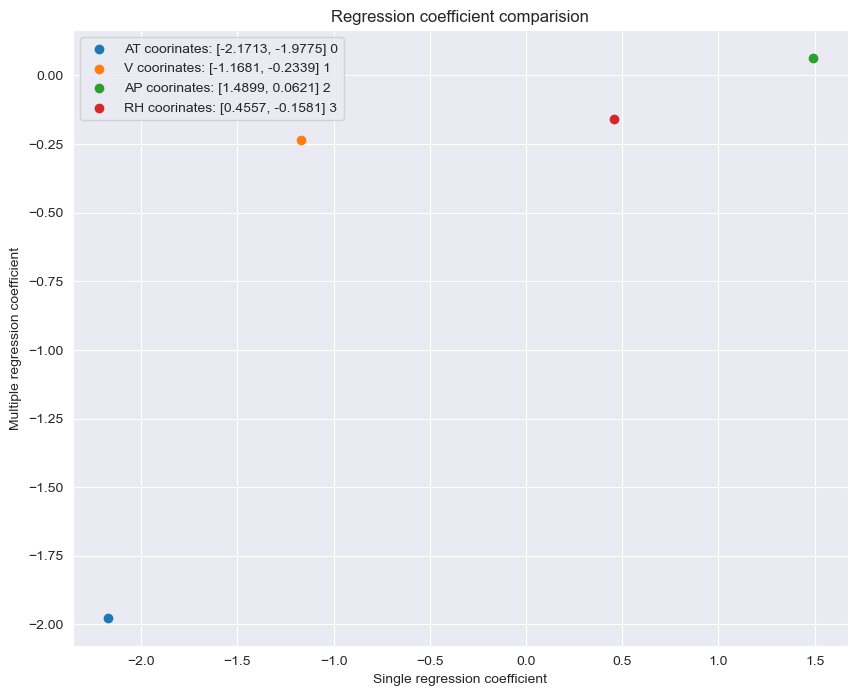

In [252]:
fig, axes = plt.subplots(figsize=(10, 8))
for i, col in enumerate(df.columns[0:len(df.columns) - 1]):
    text = f"{col} coorinates: [{round(coefficients[col][0], 4)}, {round(model_all_feature_regression.params[i], 4)}] " + str(i)
    axes.scatter(coefficients[col][0], model_all_feature_regression.params[i], label=text)
#axes.legend()

plt.legend()
plt.xlabel('Single regression coefficient')
plt.ylabel('Multiple regression coefficient')
plt.title('Regression coefficient comparision')
plt.show()

#### (f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form2
#### Y =β0 +β1X+β2X2 +β3X3 +ε


In [253]:
DEGREE = 3

def identify_non_linear_association(feature_name):
    poly = PolynomialFeatures(DEGREE)
    trainingX_poly = poly.fit_transform(df[feature_name].to_numpy().reshape(-1, 1))
    model = sm.OLS(df["PE"].to_numpy(), trainingX_poly).fit()
    print(model.summary())
display(Markdown('<left><br><font size="6">Analysis: AT </font></br></left>'.format(feature))) 
#print("\n\nFor feature: AT")
identify_non_linear_association("AT")
display(Markdown('<left><br><font size="6">Analysis: V</font></br></left>'.format(feature))) 
#print("\n\nFor feature: V")
identify_non_linear_association("V")
display(Markdown('<left><br><font size="6">Analysis: AP</font></br></left>'.format(feature))) 
#print("\n\nFor feature: AP")
identify_non_linear_association("AP")
display(Markdown('<left><br><font size="6">Analysis: RH</font></br></left>'.format(feature))) 
#print("\n\nFor feature: RH")
identify_non_linear_association("RH")

<left><br><font size="6">Analysis: AT </font></br></left>

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:18   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

<left><br><font size="6">Analysis: V</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:18   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.0

<left><br><font size="6">Analysis: AP</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:18   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.009      8.415      0.0

<left><br><font size="6">Analysis: RH</font></br></left>

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:18   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135     10.545     44.422      0.0

#### Observations:    
#### 1]Analysis: AT (Temperature)  
R-squared: 0.912  
Adj. R-squared: 0.912  
The model explains approximately 91.2% of the variation in PE.  
All coefficients (β0, β1, β2, β3) are statistically significant (p-values < 0.05).  
The model suggests a nonlinear relationship between temperature (AT) and PE.  

#### 2]Analysis: V (Exhaust Vacuum)  
R-squared: 0.775  
Adj. R-squared: 0.775  
The model explains approximately 77.5% of the variation in PE.  
The coefficient for X2 is not statistically significant (p-value = 0.768), indicating that the quadratic term (X2) may not be necessary. The relationship appears to be primarily linear with some nonlinearity.  

#### 3]Analysis: AP (Ambient Pressure)  
R-squared: 0.275  
Adj. R-squared: 0.275  
The model explains approximately 27.5% of the variation in PE.  
All coefficients (β0, β1, β2, β3) are statistically significant (p-values < 0.05).  
The model suggests a nonlinear relationship between ambient pressure (AP) and PE.  

#### 4]Analysis: RH (Relative Humidity)  
R-squared: 0.154  
Adj. R-squared: 0.153  
The model explains approximately 15.4% of the variation in PE.  
All coefficients (β0, β1, β2, β3) are statistically significant (p-values < 0.05).  
The model suggests a nonlinear relationship between relative humidity (RH) and PE.

For features AT, AP and RH, the p-value is very small and hence, we can reject the null hypothesis which means that that there is evidence of non-linear association between the predictors and the response.    

However, for predictor V, the p-value for x2 and x3 is not negligible and for x2 especially, it is of significant amount. Hence, we cannot reject the null hypothesis and hence there is no non-linear association between the predictors and the response.   

In summary, these analyses indicate that there is evidence of nonlinear associations between the predictors and the response in some cases. The models include higher-order terms (quadratic and cubic) to capture these nonlinear relationships. However, the necessity of these higher-order terms may vary among predictors, as indicated by the significance of the coefficients.  

 

#### (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [254]:
interaction_terms = 'PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
model = smf.ols(formula = interaction_terms, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:18   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

Statistical significance depends inversely on the p-value. A p-value of AT, AT * AP, and V * RH is greater than 0.05, meaning these interactions have statistically insignificant importance on the response.

For different p-values present in the output, the summarization of the results are as follows -  

Considering p = 0.05: V, AP, RH, AT:V, AT:RH, V:AP, AP:RH are statistically significant  
Considering p = 0.10, AT, V:RH are statistically significant  
AT:AP have very large p-values and are not statistically significant  

#### (h) Can you improve your model using possible interaction terms or nonlinear asso- ciations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regres- sion model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [255]:
# Initialize a dictionary to store error summaries
error_summary = {}

# Generate a list of indices from 0 to 9567
idx = [x for x in range(0, 9568)]

# Set a random seed for reproducibility
random.seed(9568)

# Shuffle the indices randomly
random.shuffle(idx)

# Calculate the size for the training set (70% of the data)
size = math.floor(len(df) * 0.7)

# Create the training set and test set using the shuffled indices
train_70 = df.iloc[idx[:size], :]
test_30 = df.iloc[idx[size:], :]

# Separate the features (X) and the target variable (y) for the entire dataset
tts_df_x = df.iloc[:, :-1]
tts_df_y = df.iloc[:, -1:]

# Split the entire dataset into training and test sets (70% train, 30% test)
train_70_x, test_30_x, train_70_y, test_30_y = train_test_split(
    tts_df_x, tts_df_y, train_size=0.7, random_state=1
)

# Print the shapes of various datasets to verify sizes
print("Shape of the original dataset:", df.shape)
print("Shape of the 70% training set:", train_70.shape)
print("Shape of the 30% test set:", test_30.shape)
print("Shape of training set features:", train_70_x.shape)
print("Shape of test set features:", test_30_x.shape)
print("Shape of training set target variable:", train_70_y.shape)



Shape of the original dataset: (9568, 5)
Shape of the 70% training set: (6697, 5)
Shape of the 30% test set: (2871, 5)
Shape of training set features: (6697, 4)
Shape of test set features: (2871, 4)
Shape of training set target variable: (6697, 1)


In [256]:
# Define a function for training a regression model
def train(mode, formula):
    # Fit the OLS regression model using the specified formula and the training dataset
    model = smf.ols(formula, train_70).fit()
    
    # Print the summary of the regression model
    print(model.summary())
    
    # Make predictions on the training and test sets
    predict_train_Y = model.predict(train_70_x)
    predict_test_Y = model.predict(test_30_x)
    
    # Calculate the mean squared error (MSE) for both training and test sets
    train_mse = mean_squared_error(train_70_y, predict_train_Y)
    test_mse = mean_squared_error(test_30_y, predict_test_Y)
    
    # Create a dictionary to store the results
    results = {
        "formula_used": formula,
        "train_mse": round(train_mse, 4),
        "test_mse": round(test_mse, 4)
    }
    
    # Update the error_summary dictionary with the MSE values
    error_summary[mode] = [train_mse, test_mse]
    
    # Create a DataFrame to display the results
    result_df = pd.DataFrame(data=results.items(), columns=['key', 'value'])
    
    return result_df



In [257]:
FORMULA_1 = "PE ~ AT + V + AP + RH"
train("all_predictors_linear_regression", FORMULA_1)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.168e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:18   Log-Likelihood:                -19620.
No. Observations:                6697   AIC:                         3.925e+04
Df Residuals:                    6692   BIC:                         3.928e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    446.0925     11.663     38.248      0.0

,key,value
0,formula_used,PE ~ AT + V + AP + RH
1,train_mse,20.7733
2,test_mse,20.7629


In [258]:
FORMULA_2 = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(V,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
train("inter_quad_terms_linear_regression", FORMULA_2)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     7171.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:18   Log-Likelihood:                -19158.
No. Observations:                6697   AIC:                         3.835e+04
Df Residuals:                    6682   BIC:                         3.845e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -6396.8126   1454.860     

,key,value
0,formula_used,"PE ~ AT + V + AP + RH + np.power(AT,2) + np.po..."
1,train_mse,18.0805
2,test_mse,18.1893


Based on the regression result above, we cannot reject the Null Hypothesis of AT,V, V^2,AT:AP,V:AP and V:RH. 
Thus, we will only remove the 2-order terms. Although AT and V have large p-value as well, removing basic predictors will violate the hierachical priciple when the AT:V is included.  

For every run, the data is shuffled to splitting into training data and testing data. Hence, the output is likely going to vary for every run. Generally, AT has had p-value > 0.05 and sometimes not.

In [259]:
FORMULA_3 = 'PE ~ AT + V + AP + RH + np.power(AT,2) + np.power(AP,2) + np.power(RH,2) + AT*V + AT*RH + AP*RH'
train("remove_insignificant_predictors_linear_regression", FORMULA_3)

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.001e+04
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        23:40:18   Log-Likelihood:                -19168.
No. Observations:                6697   AIC:                         3.836e+04
Df Residuals:                    6686   BIC:                         3.843e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.025e+04   1096.856     

,key,value
0,formula_used,"PE ~ AT + V + AP + RH + np.power(AT,2) + np.po..."
1,train_mse,18.1043
2,test_mse,18.2446


#### (i) KNN Regression:
#### i. Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k ∈ {1,2,...,100} that gives you the best fit. Plot the train and test errors in terms of 1/k.

In [260]:
# Define a function to perform k-Nearest Neighbors (KNN) regression
def performKNN(mode):
    # Initialize lists to store results
    k_rev = []
    train_error = []
    test_error = []
    min_index = 0

    # Check if the mode is "NORMALIZED" or "RAW" and preprocess data accordingly
    if mode == "NORMALIZED":
        print("NORMALIZED Mode Selected")
        scaler = MinMaxScaler()
        train_70_x_knn = scaler.fit_transform(train_70_x)
        test_30_x_knn = scaler.fit_transform(test_30_x)
    else:
        print("RAW Mode Selected")
        train_70_x_knn = train_70_x
        test_30_x_knn = test_30_x
        
    # Iterate through different values of k (number of neighbors)
    for k in range(1, 101):
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_70_x_knn, train_70_y)
        k_rev.append(1 / k)
        train_predict = knn.predict(train_70_x_knn)
        test_predict = knn.predict(test_30_x_knn)
        train_mse = mean_squared_error(train_70_y, train_predict)
        test_mse = mean_squared_error(test_30_y, test_predict)
        train_error.append(train_mse)
        test_error.append(test_mse)
        if test_mse < test_error[min_index]:
            min_index = k - 1
            
    # Store the results in the error_summary dictionary
    error_summary[mode] = [train_error[min_index], test_error[min_index]]
    
    # Create a summary dictionary with the key results
    summary = {
        "mode": mode,
        "train_error": round(train_error[min_index], 4),
        "test_error": round(test_error[min_index], 4),
        "k_rev": k_rev,
        "k": round((1 / k_rev[min_index]), 4)
    }
    
    # Create an attributes dictionary to store additional data
    attributes = {
        "k_rev": k_rev,
        "train_error": train_error,
        "test_error": test_error,
        "error_summary": error_summary
    }
    
    return [summary, attributes]

# Define a function to plot the KNN regression results
def plot_graph(k_rev, train_error, test_error):
    plt.plot(k_rev, train_error, label="Train Mean Squared Error")
    plt.plot(k_rev, test_error, label="Test Mean Squared Error")
    plt.gca().set_xlabel("1/k")
    plt.gca().set_ylabel("Mean Squared Error")
    plt.gca().legend()
    plt.show()

In [261]:
[info, attr] = performKNN("RAW")
info_temp = {
    "mode": info["mode"],
    "k": info["k"],
    "train_error": info["train_error"],
    "test_error": info["test_error"]
}
pd.DataFrame(info_temp.items())

RAW Mode Selected


,0,1
0,mode,RAW
1,k,5.0
2,train_error,10.553
3,test_error,15.7048


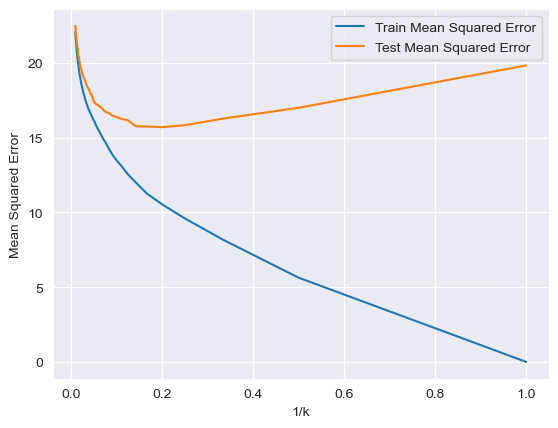

In [262]:
plot_graph(attr["k_rev"], attr["train_error"], attr["test_error"])


In [263]:
[info, attr] = performKNN("NORMALIZED")
info_temp = {
    "mode": info["mode"],
    "k": info["k"],
    "train_error": info["train_error"],
    "test_error": info["test_error"]
}
pd.DataFrame(info_temp.items())


NORMALIZED Mode Selected


,0,1
0,mode,NORMALIZED
1,k,7.0
2,train_error,11.0119
3,test_error,14.9106


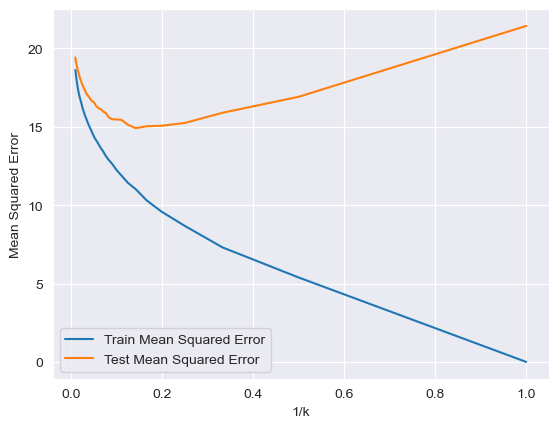

In [264]:
plot_graph(attr["k_rev"], attr["train_error"], attr["test_error"])

##### (j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.


In [265]:
map_temp = {}
for key, value in attr["error_summary"].items():
    map_temp[key] = [round(elem, 4) for elem in value]

map_temp
pd.DataFrame(data=map_temp.items(), columns=["Mode", "[Train Error, Test Error]"])


,Mode,"[Train Error, Test Error]"
0,all_predictors_linear_regression,"[20.7733, 20.7629]"
1,inter_quad_terms_linear_regression,"[18.0805, 18.1893]"
2,remove_insignificant_predictors_linear_regression,"[18.1043, 18.2446]"
3,RAW,"[10.553, 15.7048]"
4,NORMALIZED,"[11.0119, 14.9106]"



#### We observed the lowest test MSE with linear regression in (1h) part was around  18, while the lowest test mse for KNN regression was around 15. Thus, by simply observing the MSE of test data, we can say that KNN regression is a better predictor than linear regression. Reason can be the non-linear nature of data.  

### 2. ISLR: 2.4.1
For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.     
(a) The sample size n is extremely large, and the number of predictors p is small.  
(b) The number of predictors p is extremely large, and the number
of observations n is small.  
(c) The relationship between the predictors and response is highly
non-linear.  
(d) The variance of the error terms, i.e. σ2 = Var(ϵ), is extremely
high.  

#### [2a] The sample size n is extremely large, and the number of predictors p is small

Large sample size along with small number of predictors can cause the model to underfit if the model is an inflexible statistical learning method. Hence, a flexible model will perform better than an inflexible model.

#### [2b] The number of predictors p is extremely large, and the sample size n is small

Small sample size along with large number of predictors will cause a flexible model to overfit. Hence, a flexible model will perform worse than an inflexible model.

#### [2c] The relationship between the predictors and response is highly non-linear

Flexible method would perform better than the inflexible models. Since the flexible models could have complex interactions between the predictors or quadratic function in the formula, it would be the right fit when there is a non-linearity between predictors and response compared to inflexible models

#### [2d] The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high

High variance = More noise which means that a flexible model will overfit. Overfitting is a bad thing and hence, here, a flexible statistical model will perform worse as compared to an inflexible models.

### 3. ISLR: 2.4.7
The table below provides a training data set containing six observations, three predictors, and one qualitative response variable.  
X1 X2 X3 Y  
    1 0 3 0 Red  
    2 2 0 0 Red  
    3 0 1 3 Red  
    4 0 1 2 Green  
    5 −1 0 1 Green  
    6 1 1 1 Red  
Suppose we wish to use this data set to make a prediction for Y when X1 = X2 = X3 = 0 using K-nearest neighbors.  
(a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.  
(b) What is our prediction with K = 1? Why?  
(c) What is our prediction with K = 3? Why?  
(d) If the Bayes decision boundary in this problem is highly nonlinear, then would we expect the best value for K to be large or small? Why?  

#### [3a]  The Euclidean distance between each observation and point X1 = X2 = X3 = 0

Euclidean distance of different observation points from point ($x_1 = 0$, $x_2 = 0$,$x_3 = 0$) is: 

sample 1 = $\sqrt{(3-0)^2 + (0-0)^2 + (0-0)^2}$ = 3

sample 2 = $\sqrt{(2-0)^2 + (0-0)^2 + (0-0)^2}$ = 2

sample 3 = $\sqrt{(3-0)^2 + (1-0)^2 + (0-0)^2}$ = 3.16

sample 4 = $\sqrt{(2-0)^2 + (1-0)^2 + (0-0)^2}$ = 2.2

sample 5 = $\sqrt{(1-0)^2 + (-1-0)^2 + (0-0)^2}$ = 1.41

sample 6 = $\sqrt{(1-0)^2 + (1-0)^2 + (1-0)^2}$ = 1.73

#### [3b] What is our prediction with K = 1? Why?

When K = 1, the nearest first neighbouring point is sample point 5. Thus our prediction would be Green.

#### [3c] What is our prediction with K = 3? Why?

When K = 3, three nearest neighbouring points are sample point 5, 6 and 2. Sample point 2 and 6 has label Red and sample point 5 has label Green. Thus our prediction would be the majority label Red.

#### [3d] If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

K-value should be small. When K is large, the model would have high bias and less variance because the model would try to predict the feature value based on many neighbors. This would mean that the decision boundary would show more like a linear behavior. In contrast to this, when k is large, the model will have high variance. This would mean that the model with a small K would be highly non-linear.The value of K is inversely proportional to the flexibility of the module. As K increases, a more linear boundary is achieved. Since the question states that the decision boundary of the problem is highly non-linear, the value of K would this be small.